In [1]:
from netCDF4 import Dataset
from cartoplot import cartoplot
import numpy as np
import datetime
from pyproj import Proj, transform
from scipy.spatial.kdtree import KDTree
import pandas as pd
import matplotlib.pyplot as plt
from ll_xy import lonlat_to_xy
import cartopy.crs as ccrs
import cartopy
import pickle
from ll_xy import lonlat_to_xy

/tmp/ipykernel_14529/823917642.py:6: DeprecationWarning: Please import `KDTree` from the `scipy.spatial` namespace; the `scipy.spatial.kdtree` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.spatial.kdtree import KDTree


In [2]:
floe_tracks = [
'../data/2022-04-11-trajectory.csv',
'../data/2022-04-16-trajectory.csv',
'../data/2022-04-17-trajectory.csv',
'../data/2022-04-19-trajectory.csv',
'../data/2022-04-22-trajectory.csv',
]

dfs = []
for f in floe_tracks:
    
    dfs.append(pd.read_csv(f,parse_dates=['date'])   )

In [3]:
d = Dataset(f'../data/ERA5/2022_weather.nc')

ERA_lat_grid = np.tile(np.array(d['latitude']),(d['longitude'].shape[0],1)).T

ERA_lon_grid = np.tile(np.array(d['longitude']),(d['latitude'].shape[0],1))

ERA_x,ERA_y = lonlat_to_xy(ERA_lon_grid,ERA_lat_grid,hemisphere='s')
tree = KDTree(list(zip(ERA_x.ravel(),ERA_y.ravel())))

In [4]:
data_dict = {}

for year in [2021,2022]:
    
    data_dict[year] = {}
    
    d = Dataset(f'../data/ERA5/{year}_weather.nc')
    
    dt0 = datetime.date(1900,1,1)

    dts = [dt0 + datetime.timedelta(hours=int(d)) for d in d['time']]
    
    data_dict[year]['d'] = d
    data_dict[year]['dts'] = dts

In [5]:
for df in dfs:
    
    ind_i, ind_j = [], []
    
    for x, y in zip(df['x'],df['y']):

        dist, ind = tree.query((x,y))
        
        unraveled = np.unravel_index(ind, ERA_lat_grid.shape)
        
        ind_i.append(unraveled[0])
        ind_j.append(unraveled[1])
        
    df['ind_i'] = ind_i
    df['ind_j'] = ind_j

In [37]:
for df in dfs:
    
    df['year'] = [x.year for x in df['date']]
    
    temps = []; tps = []
    
    for year in [2022,2021]:
        
        df_yr = df[df['year'] == year]
        
        dts = data_dict[year]['dts']
        d = data_dict[year]['d']
        
        ERA_temps = []; ERA_tps = []
        
        for i,j,date in zip(df_yr['ind_i'], df_yr['ind_j'],df_yr['date']):
            date = date.to_pydatetime().date()
            mask = np.argwhere([1 if x == date else 0 for x in dts])
            start = mask[0][0]; end = mask[-1][0]
            
            ERA_temps.append( np.mean(d['t2m'][start:end,i,j]) - 273.15)
            ERA_tps.append( np.sum(d['tp'][start:end,i,j])*1000 )
            
        temps = temps + ERA_temps
        tps = tps + ERA_tps
        
    df['ave_temp'] = temps
    df['sum_tp'] = tps
            


In [39]:
last_warm_days = []
for df in dfs:
    last_warm_days.append(df['date'][np.argmax(df['ave_temp']>=0)])

94.2724004683226
96.50669229164663
82.95679954647665
104.96066547354381
84.48352026862618


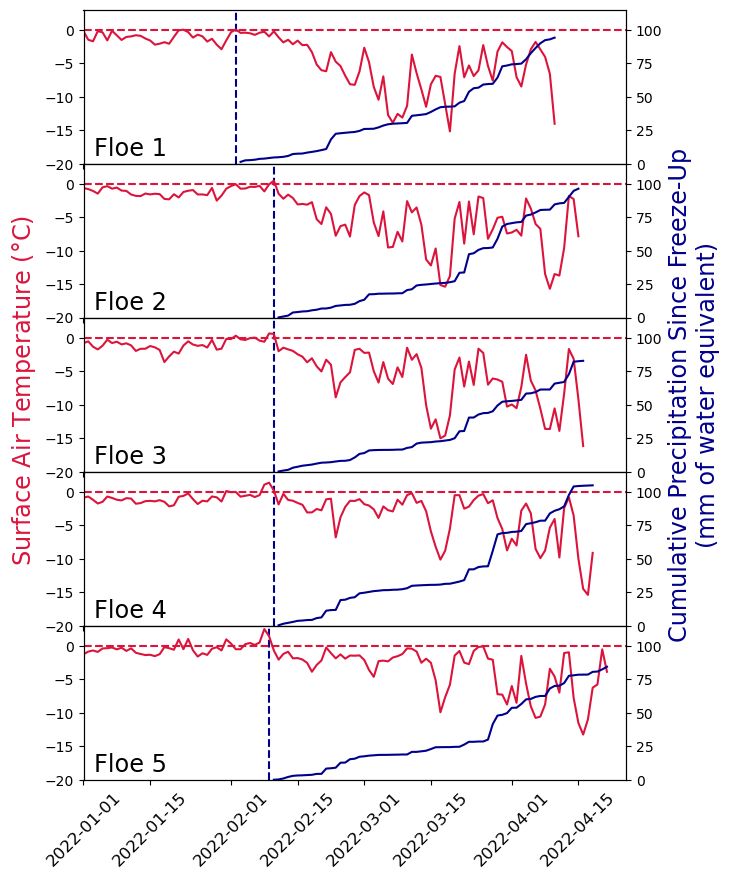

In [40]:


fig, axs = plt.subplots(5,1,figsize=(7,10))
    
for counter, (df, lwd, ax) in enumerate(zip(dfs,last_warm_days,axs.reshape(-1))):
    
    ax2 = ax.twinx()
    
    df_cold = df[df['date']>lwd].sort_values('date')
    
    df_cold['cum_tp'] = np.cumsum(df_cold['sum_tp'])
    
    print(np.max(df_cold['cum_tp']))
    
    ax.set_xlim(datetime.date(2022,1,1),datetime.date(2022,4,25))
    
    ax.axvline(lwd,color='darkblue',ls='--')
    ax.set_ylim(-20,3)
    
    ax.plot(df['date'],df['ave_temp'],color='crimson')
    ax.axhline(0,ls='--',color='crimson')
    
    ax2.plot(df_cold['date'],df_cold['cum_tp'],color='darkblue')
    
    ax2.set_ylim(0,0.115*1000)
    
    ax.annotate(f'Floe {counter + 1}', fontsize='xx-large',xy=(0.02,0.05),
                xycoords='axes fraction')
    
    if counter != 4:
        ax.set_xticklabels([])
        
    if counter ==2:
        ylab = 'Cumulative Precipitation Since Freeze-Up\n(mm of water equivalent)'
        ax2.set_ylabel(ylab,
                       fontsize='xx-large',
                       color='darkblue')
    

ax.xaxis.set_tick_params('major',rotation=45,labelsize='large')
fig.subplots_adjust(hspace=0)


fig.supylabel('Surface Air Temperature ($\degree$C)',fontsize='xx-large',color='crimson')

# plt.savefig('../figures/floe_weather.jpg',dpi=400,bbox_inches='tight')

plt.show()

# Code to download the required weather data

In [1]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            '2m_temperature',
            'precipitation_type',
            'total_precipitation',
        ],
        'year': '2021',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            -60, -70, -80,
            -2,
        ],
    },
    '../data/ERA5/2021_weather.nc')

import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            '2m_temperature',
            'precipitation_type',
            'total_precipitation',
        ],
        'year': '2022',
        'month': [
            '01',
            '02',
            '03',
            '04',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            -60, -70, -80,
            -2,
        ],
    },
    '../data/ERA5/2022_weather.nc')

2023-01-13 17:42:13,409 INFO Welcome to the CDS
2023-01-13 17:42:13,410 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-01-13 17:42:13,792 INFO Request is completed
2023-01-13 17:42:13,793 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data3/adaptor.mars.internal-1673577362.091265-28152-17-d6f69431-8392-4f4a-a632-3e911a1d8ffb.nc to 2021_weather.nc (1.1G)


KeyboardInterrupt: 